In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, clear_output
from time import sleep
# from livelossplot import PlotLosses
import tensorflow as tf
import tensorflow.keras.initializers as initializers
import numpy as np
import seaborn as sns; 
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from scipy.stats import norm, uniform, multivariate_normal
from scipy.special import softmax
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
slim = tf.contrib.slim
from tqdm.notebook import tqdm
import sys
from scipy.linalg import block_diag
sys.path.append('../models/')
sys.path.append('../')
from ratio_utils_highdim_exp_fam_par import *
tf.keras.backend.set_floatx('float32')
print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

0.7950600976206501
39.99999999999999
-107.03017
1.15.0


In [2]:
n_dims = 160
num_samples=100000
mi = 40
bs=1000
N=1200
deep=False
reset(4)

def get_rho_from_mi(mi, n_dims):
    """Get correlation coefficient from true mutual information"""
    x = (4 * mi) / n_dims
    return (1 - np.exp(-x)) ** 0.5  # correlation coefficient
        
def get_data(mu_1=0.,mu_2=2.,mu_3=2.,scale_p=0.1,scale_q=0.1,scale_m=1.):
    
    p_dist = multivariate_normal(mean=mu_1,cov=scale_p)
    
    q_dist = multivariate_normal(mean=mu_2,cov=scale_q)
      
#     m_dist = tfp.distributions.Mixture(
#           cat=tfp.distributions.Categorical(probs=[.7,.3]),
#           components=[
#             p,
#             q, 
#         ])
    
#     m = tfp.distributions.MultivariateStudentTLinearOperator(
#     df=1.,
#     loc=mu_2,
#     scale=tf.linalg.LinearOperatorLowerTriangular(scale_m))
    
    p_samples_ = p_dist.rvs(size=num_samples) 
    q_samples_ = q_dist.rvs(size=num_samples)

    alpha = np.expand_dims(np.reshape(np.repeat([0.,0.25,0.5,.75,1.],num_samples//5),[num_samples]),1) #[0.05,0.25,0.6,.85,0.95] MI = 40
#     alpha = np.expand_dims(np.reshape(np.repeat([0.,.125,.25,.375,.45,.55,.625,.75,.875,1.],num_samples//10),[num_samples]),1) #MI = 120

#     m_samples_ = tf.sqrt(1-alpha**2)*p_samples_ + alpha*q_samples_ 
    m_samples_ = (1-alpha)*p_samples_ + alpha*q_samples_ 
    
#     m_samples_ = m.sample([num_samples]) 
    
    p_dist_return = tfd.MultivariateNormalFullCovariance(
        loc=mu_1,
        covariance_matrix=scale_p)
    
    q_dist_return = tfd.MultivariateNormalDiag(
        loc=mu_2,
        scale_diag=scale_q)
    
    return p_dist_return, q_dist_return, p_samples_, q_samples_, m_samples_

# Define data param
rho = get_rho_from_mi(mi, n_dims)  # correlation coefficient
print(rho)
rhos = np.ones(n_dims // 2, dtype="float32") * rho

mu_1=np.zeros((n_dims), dtype="float32") #-0.5+
mu_2=np.zeros((n_dims), dtype="float32") #0.6+
mu_3=np.zeros((n_dims), dtype="float32")

scale_p = block_diag(*[[[1, rho], [rho, 1]] for _ in range(n_dims // 2)])
scale_p = np.float32(scale_p)
scale_q = np.ones(n_dims, dtype="float32")
scale_m = 1*np.eye(n_dims, dtype="float32")

# Generate dataset
p, q, p_list, q_list, m_list = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)
_, _, p_list_test, _, m_list_test = get_data(mu_1,mu_2,mu_3,scale_p,scale_q,scale_m)

print(p_list.shape)



0.7950600976206501
(100000, 160)


In [3]:
print(np.mean(p_list_test,0))

[ 6.93413834e-05 -1.20818959e-03  6.12579061e-03  4.88386618e-03
 -1.96697139e-03  3.20033825e-04 -4.38913958e-03 -4.42453999e-03
  3.70902753e-03  6.36409278e-03 -8.86776641e-03 -8.95175816e-03
 -6.67769494e-04  3.71851293e-04  9.21755951e-04 -9.30336553e-05
  4.18319878e-03  4.75134550e-03  7.66160295e-03  3.30433869e-03
  4.37754740e-03  4.86075715e-03 -1.73827776e-03 -1.29079843e-03
 -4.19274178e-03 -3.09973267e-03 -3.56819346e-04  5.98694804e-04
  1.10790603e-03  1.28685890e-03  2.22991058e-03  4.22086762e-03
 -5.25215221e-03 -5.15513242e-03 -4.40085670e-03 -3.01310422e-03
 -4.55968728e-03 -4.20784206e-03  2.20735133e-04 -4.44277755e-05
 -1.14496480e-03  1.24802842e-03 -3.49722930e-04 -2.43107802e-03
 -2.30405704e-04 -1.01935431e-03 -3.21968090e-03 -1.45497670e-03
 -2.11826555e-03 -1.91235351e-03 -1.43505795e-03 -2.40268987e-03
  1.31066310e-03  6.25860909e-04  1.07802821e-02  5.79393178e-03
 -4.39148577e-03 -3.86197629e-03  3.07071899e-03  4.12057042e-03
  2.20397708e-03  1.36689

[[-438.51367 -493.4442  -450.     ]
 [-436.27298 -485.10904 -450.     ]
 [-431.59546 -462.94357 -450.     ]
 ...
 [-424.65564 -462.1951  -450.     ]
 [-435.81595 -480.94714 -450.     ]
 [-429.60376 -481.71573 -450.     ]]
[[-542.05365 -435.56256 -450.     ]
 [-520.8592  -464.95822 -450.     ]
 [-470.5498  -422.9291  -450.     ]
 ...
 [-511.9492  -444.23346 -450.     ]
 [-531.70135 -455.54984 -450.     ]
 [-449.3138  -423.692   -450.     ]]
[[-403.64996 -428.6965  -450.     ]
 [-407.78174 -436.80548 -450.     ]
 [-395.88495 -406.89487 -450.     ]
 ...
 [-447.19577 -518.7802  -450.     ]
 [-451.8359  -497.95193 -450.     ]
 [-476.9762  -410.2578  -450.     ]]

0.0
0.0
0.0


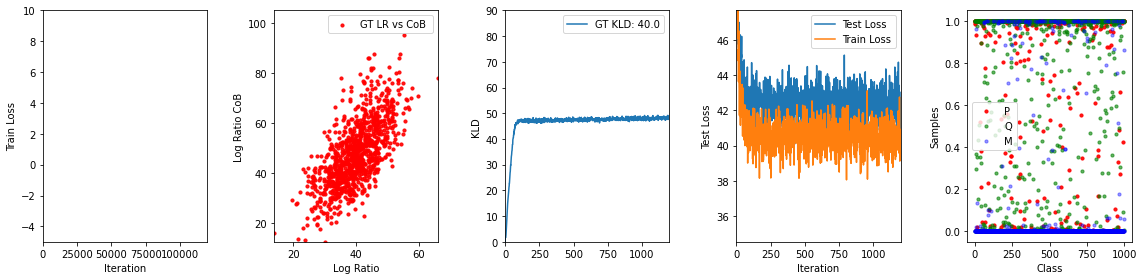

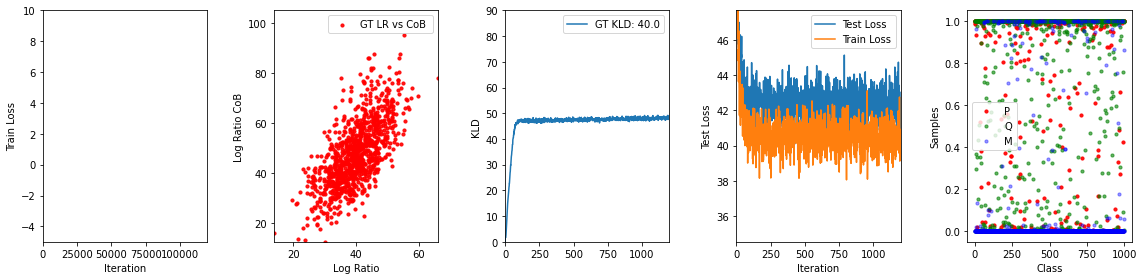

In [4]:
p_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
q_samples = tf.placeholder(tf.float32, shape=[None,n_dims])
m_samples = tf.placeholder(tf.float32, shape=[None,n_dims])

dloss = get_loss(p_samples, q_samples, m_samples, None, deep=deep)
optim = get_optim(dloss,lr=5e-4)#,lr=5e-3,b1=.99

log_ratio_p_q, _ = get_gt_ratio_kl(p,q,p_samples)
_, kl_from_pq = get_gt_ratio_kl(p,q,p_samples)
kl_from_cob = get_kl_from_cob(p_samples, q_samples)

log_ratio_p_m = get_logits(p_samples,deep=deep, training=False)
logit_q = get_logits(q_samples,deep=deep, training=False)
logit_m = get_logits(m_samples,deep=deep, training=False)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
[kl_gt] = sess.run([p.kl_divergence(q)],feed_dict={})

fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(1, 5,figsize=(16,4))

line, = ax1.plot([0,1],[0,1])
test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')
kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(kl_gt))
x, y = np.random.random((2, 500))
np.random.randint
scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

scat_p = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='P',alpha=0.9,s=10.,c='r')
scat_q = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='Q',alpha=0.6,s=10.,c='g')
scat_m = ax5.scatter(range(bs),np.random.randint(0,2,bs),label='M',alpha=0.4,s=10.,c='b')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,N*(num_samples//bs)])
ax1.set_ylim([-5,10])

ax2.set_xlabel("Log Ratio")
ax2.set_ylabel("Log Ratio CoB")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Test Loss")
ax4.set_xlim([0,N//50])
ax4.set_ylim([-5,10])
ax4.legend(loc='best')

ax5.set_xlabel("Class")
ax5.set_ylabel("Samples")
ax5.legend(loc='best')


plt.tight_layout()
loss_store=[]
test_loss_store=[]
test_loss_store1=[]
kld_store=[]
pbar = range(0,N)
for j in pbar:
    for i in range(num_samples//bs):
        ps = p_list[np.random.choice(range(len(p_list)),bs)]
        qs = q_list[np.random.choice(range(len(q_list)),bs)]
        ms = m_list[np.random.choice(range(len(m_list)),bs)]
        feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
        
        l,_ = sess.run([dloss, optim],feed_dict=feed_dict)
        loss_store.append(l)
        
        if i%100==0:
            line.set_data(range(len(loss_store)), loss_store)
            ax1.set_xlim( 0, len(loss_store) )
            
            ps = p_list_test[np.random.choice(range(len(p_list_test)),bs)]
            qs = q_list[np.random.choice(range(len(q_list)),bs)]
            ms = m_list_test[np.random.choice(range(len(m_list_test)),bs)]
            feed_dict = {p_samples:ps, q_samples:qs, m_samples:ms}
            
            testl, lpq, lpqm, kl_cob, l_q, l_m = sess.run([dloss, log_ratio_p_q, log_ratio_p_m, kl_from_cob, logit_q, logit_m],feed_dict=feed_dict)
            kld_store.append(kl_cob)
            test_loss_store.append(testl)
            test_loss_store1.append(l)
#             cob = np.log([max(1e-10,n_[0]/n_[1]) for n_ in lpqm])
        
            cob=lpqm[:,0] - lpqm[:,1]
            scat.set_offsets(np.asarray([lpq,cob]).T)
            ax2.set_xlim( lpq.min(), lpq.max() )
#             ax2.set_ylim( lpq.min()-30, lpq.max()+10 )
            ax2.set_ylim( cob.min(), cob.max()+10 )

            kld_line.set_data(range(len(kld_store)),kld_store)
            ax3.set_xlim( 0, len(kld_store) )
            ax3.set_ylim( 0, kl_gt+50 )
#             ax3.set_ylim( 0, min(max(kld_store),500) )
            
            test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
            test_line.set_data(range(len(test_loss_store)), test_loss_store)
            ax4.set_xlim( 0, len(test_loss_store) )
            ax4.set_ylim([l.min()-5,testl.max()+5])
            
            
            
            scat_p.set_offsets(np.asarray([range(bs),softmax(lpqm,axis=1)[:,0]]).T)
            scat_q.set_offsets(np.asarray([range(bs),softmax(l_q, axis=1)[:,1]]).T)
            scat_m.set_offsets(np.asarray([range(bs),softmax(l_m, axis=1)[:,2]]).T)
            
             
            
            clear_output(wait=True)
            
            sp = (lpqm)
            sq = (l_q)
            sm = (l_m)
            print(sp)
            print(sq)
            print(sm)
            
            print(dloss.device)
            
            print(np.mean(np.exp(lpqm[:,0])))
            print(np.mean(np.exp(l_q[:,1])))
            print(np.mean(np.exp(l_m[:,2])))
            
#             if ( sp>0.99 and sq > 0.99 and sm>0.99 ):
#                 sys.exit(0)
                                                                                
            
            display(fig)
        


# sample_and_plot(sess, kld, kl_from_pq, kl_from_cob, p_samples, q_samples, m_samples, log_ratio_p_q, log_ratio_p_m, mu_1, mu_2, scale_p, scale_q, mu_3, scale_m)



    

In [9]:
print(np.std(kld_store[-200:]),np.mean(kld_store[-200:]))

0.431404 48.106434


In [6]:
def kl(m1, s1, m2, s2):
    return np.log(s2)-np.log(s1)+(s1**2 + (m1-m2)**2)/(2*s2**2)-1/2

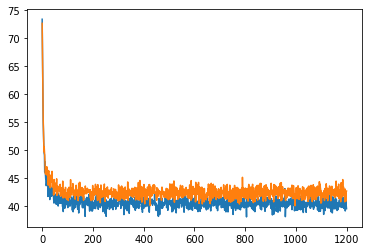

In [7]:
plt.plot(test_loss_store1[:])
plt.plot(test_loss_store[:])

In [8]:
(kld_store)

[0.09099988,
 1.8832576,
 1.6435562,
 1.6590099,
 1.7403716,
 2.135701,
 2.64783,
 3.4156046,
 4.578256,
 5.6583905,
 7.071204,
 8.396466,
 9.525717,
 10.522182,
 11.810047,
 12.733249,
 13.282507,
 14.32898,
 14.895824,
 15.391085,
 16.275843,
 16.809408,
 17.519516,
 17.90777,
 18.310421,
 19.081408,
 19.908493,
 20.769703,
 21.40962,
 21.638168,
 22.695555,
 22.693504,
 23.672995,
 24.79185,
 25.52557,
 26.40404,
 26.923292,
 27.214138,
 28.200703,
 29.175772,
 29.931824,
 29.820593,
 30.832989,
 31.410547,
 32.15849,
 33.148907,
 33.463043,
 33.889706,
 34.635864,
 35.33771,
 35.407898,
 36.5361,
 36.99093,
 37.866703,
 37.83658,
 38.01585,
 39.698044,
 40.00873,
 40.387783,
 40.524048,
 40.540688,
 41.494694,
 41.475296,
 42.738655,
 41.924644,
 42.583908,
 43.03509,
 43.621113,
 43.377186,
 43.98715,
 44.658882,
 44.339302,
 44.267902,
 45.614876,
 45.050995,
 45.506344,
 45.23937,
 45.715233,
 45.700775,
 46.337666,
 46.002083,
 45.6301,
 46.319572,
 46.25356,
 46.097492,
 46.27